(Model-based) Compressed sensing and applications
============================================

<div style="text-align: right"> Jean-Luc Bouchot, Ph.D. <br> School of Mathematics and Statistics <br> Beijing Institute of Technology <br> jlbouchot@gmail.com </div>

This short course is intended to give you an overview of compressed sensing and will give recent developments in terms of model-based compressed sensing, in which more prior knowledge than plain sparsity is added. 
This note is obviously very brief and should be complemented with further readings, targetting your own tastes and goals. 

Introduction
-----------------

We look into some small examples where sparse approximation is used in signal and image processing. 
One way to understand CS in layman's term is **Occam's razor**: _in case of two competing models, the simpler one should prevail_. 
Here _simplicity_ is understood as the number of non-zero, which turns out to be the sparsity of a given (finite-dimensional) signal. 

### Sparse Fourier signals
We look here at the problem of sampling a 1-D signal which we know (or hope) to have few non-zero active frequencies. 

To look at this, let us introduce a discrete signal with $N$ entries $x$. $x$ is assumed to come from a sparse Fourier signal, i.e. $x = Ff$ with $F$ the $N \times N$ DFT and $f$ the $N$ dimesional Fourier components of $x$. 
The sparsity assumption of $f$ reads 
$$
f = \sum_{j=1}^s f_{i_j}e_{i_j}
$$
with $s < N$ (and actually much smaller).
The goal is to take as few sample as possible of $x$ whilst being able to _invert_ the DFT, i.e. reconstruct $f$. 


1000
4000
0.0004749813262579137


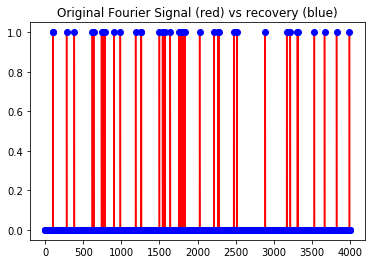

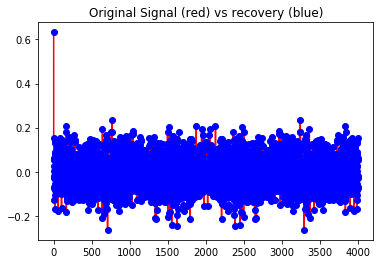

In [14]:
# Allows to plot within the document
%matplotlib inline

# Some important libraries 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# A self defined package containing certain important procedures
import RecoveryAlgo as RA

# Define some parameters
N = 4000 # Ambient dimension
s = 40 # number of non zero elements

# Frequency vector
f = np.zeros(N)
# Populate the frequencies
S = np.random.choice(N, s, replace=False) # Generate the support of the frequencies
f[S] = 1 # One could put something else here ... 

# Now define the measurement process 
m = 1000 # Number of measurements
idx_measurements = np.sort(np.random.choice(N, m, replace=False)) # These are the indices we will keep 
whole_DFT = RA.DFT_matrix(N)
A = whole_DFT[idx_measurements,:]
# Create the measurement vector
y = np.dot(A,f)

# And recover via convex optimization (see later for details)
f_hat = RA.BasisPursuit(y,A, 1e-10)
print(np.linalg.norm(f-f_hat))

plt.plot(np.arange(N), f, 'r')
plt.plot(np.arange(N), f_hat, 'bo')
plt.title('Original Fourier Signal (red) vs recovery (blue)')
plt.show()

plt.plot(np.arange(N), np.real(np.dot(whole_DFT,f)), 'r')
plt.plot(np.arange(N), np.real(np.dot(whole_DFT,f_hat)), 'bo')
plt.title('Original Signal (red) vs recovery (blue)')
plt.show()

**Exercise**: Try to adapt the parameters and see when the recovery is possible and when not. 

**Exercise**: What happens if you add a bit of noise to it? (see for instance the np.random.random() command)

### MRI recovery from TV variation minimization 
Another important practical example is the one of MRI reconstruction. 
Here however, the sparsity is not on the pixel level, but on the gradient of the image; it is indeed expected that an MRI has just a few large flat regions. 


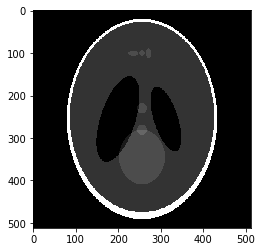

In [19]:
import phantom as pht

N = 512

sl_phantom = pht.phantom(N)
# imgplot = plt.imshow(I, cmap='gray')
plt.imshow(sl_phantom, cmap='gray')
plt.show()

We will once again consider Fourier measurements of the given image by subsampling the (2D) Fourier matrix. 

Note that because CVX hardly deals with such complicated things, we will use an approximation of the TV minimization with L2 data fidelity based on Primal-Dual algorithm. (This was done in Matlab for a previous project and re-used here.)
Using a TV minimization <img src="imgs/Phantom_noiseless_FCS_TV.png" width="256">

Using an $\ell_1$ analysis approach<img src="imgs/Phantom_noiseless_L1-Analysis.png" width="256">



### What have we done so far? 

While the first problem can be seen as pure compressed sensing (although this is debatable, the signal is not sparse by itself but only on a Fourir basis which means that we need an extra step to actually reconstruct the signal that we sampled), the second one clearly isn't. It is only sparse in its gradient and as such already constitutes an example of model-based compressed sensing, i.e. a sparse approximation in which we have added the knowledge of the _basis_ to use. 

### Basic notations and definitions

Throughout this course, we will use the following notations 
* $x$ denotes a general $N$-dimensional discrete signal. We will mainly work on $\mathbb{R}^N$ but its entries could also be complex.
* $N$ is called the _ambient dimension_. 
* $y$ is usually the measurements vector, containing $m$ samples obtained by taking inner products between $x$ and known vectors $a_i$, $1 \leq i \leq m$. 
* $m$ is the number of samples. Compressed sensing works in the undersampling regime: $m \leq N$. 
* We assume $x$ to be sparse, i.e. $\operatorname{card}(\operatorname{supp}(x)) = s \ll N$. 
* The sparsity is often described as the _$\ell_0$ norm_, i.e. $s = \|x\|_0$
* $A \in \mathbb{R}^{m \times N}$ is the mesaurement matrix (sometimes called design matrix or sampling matrix). We obviously have $y = Ax$. 

The **goal of compressed sensing** is to find the following:
* A (linear) measurement matrix $A \in \mathbb{R}^{m \times N}$ and 
* A non-linear recovery procedure $\Delta: \mathbb{R}^m \to \mathbb{R}^N$ such that 
$$
\Delta(Ax) = x, \quad \text{for any } x \in \mathbb{R}^N, \quad x \text{ is $s$ sparse.}
$$

In certain cases, the signal $x$ is not exactly sparse (think of a wavelet expansion in natural images) or the measurements are corrupted (due to some outside reasons or simply because of quantization / numerical computations) and we therefore need to relax the equality above as well as the sparsity constraint to account for such issues. We talk about 
* **stability**: consider $x$ to be _compressible_ instead of just $s$ sparse. A signal is said to be compressible if its best $s$ term approximation $\sigma_s(x)_p := \min_{z: \|z\|_0 \leq s}\|x-z\|_p$ decays rapidly. 
* **robustness**: we analyze the quality of the recovery depending on the energy of the input noise; $\|x - \Delta(Ax)\| \asymp \varepsilon$, where $y = Ax + e$ and $\|e\| = \varepsilon$. 

### Recovery: first results

**Proposition** 

Let $x$ be an $s$-sparse signal in $\mathbb{R}^N$. The following statements are equivalent
* $x$ is the unique $s$-sparse solution of $Az = y = Ax$. 
* $x$ is the unique solution of 
$$
\tag{l0min} \min_{z \in \mathbb{R}^N}\|z\|_0, \quad \text{s.t. } Az = y.
$$

$\Rightarrow$ hence recovering the original vector $x$ is _simply_ done by solving the (combinatorial) problem above. 

### Recovery: another procedure and minimal number of measurements

An important part of any sensing/recoery design is to know how many samples are required; ideally, the fewer the number of samples, the better (faster / cheaper) the system is. In the context of sparse recovery, we have the following result 

**Proposition**
Let $A$ be an $m \times N$ sensing matrix in $\mathbb{R}^N$. The following statements are equivalent
* Every $s$-sparse $x$ is the unique $s$-sparse solution of $Az = Ax$.
* $\operatorname{ker}(A) \cap \{ x \in \mathbb{R}^N: \|x\|_0 \leq 2s \} = \{0\}$. 
* Let $S \subset \{1,\cdots, N\}$ be any set with $|S| \leq 2s$. The submatrix $A_S$ is injective.
* Every set of $2s$ columns of $A$ is linearly independent.

_Proof_ will be done in the exercise sessions. Conclude on the minimal number of measurements needed. 

**Theorem** (Recovery from Fourier matrices with _Prony's method_): 



## Basis pursuit and first recovery conditions 

As stated in the previous section, one can recover sparse vectors by minimizing the size of the support, which turns out to be an NP-hard problem. 
This section introduces an efficient algorithm for the recovery of sparse signals. It is based on convex optimization for which efficient solvers exist. 

### Basis pursuit 

Remember: $x \in \mathbb{R}^N$ is the sought after signal, $y = Ax \in \mathbb{R}^m$ is the vector of measurements, for a given design matrix $A = \mathbb{R}^{m \times N}$. 

Consider the following mathematical program 
$$
\operatorname{minimize} \|z\|_1, \quad \text{ subject to } Az = y.
$$
This is known as the **basis pursuit**. Intuitively, it tries to minimize the $\ell_1$ norm instead of the size of the support, while satisfying the measurements. 

* Advantage of $\ell_1$ over $\ell_2$: smaller elements are much more penalizing than when using an $\ell_2$ norm. (think $1e-3$ vs its square ... ). Geometrically speaking, the $\ell_1$ balls are _spikier_ and the spikes are aligned with the canonical axis. 
<img src="imgs/L1Balls.png" width="512">
* Minimizers are unique (convex optimization)
* Computationnally, the $\ell_1$ minimization is solved after recasting as a linear optimization program: 
$$
\operatorname{minimize}_{c,z} \sum c_i, \quad \text{ subject to } Az = y \text{ and } -c_j \leq z_j \leq c_j.
$$

(Remark: in the complex setting, it can be recast as a second order cone program, for which efficient solvers exist too!)

### Sparse recovery via BP and null-space property
**Definition** (_null space property_): 
A matrix $A \in \mathbb{R}^{m \times N}$ is said to satisfy the null space property of order $s > 0$ if 
$$
\|x_S\|_1 < \|x_{\bar{S}}\|_1, \quad \text{ for all } x \in \operatorname{Ker}(A)
$$
for all support set $S$ of size $|S| \leq s$. 

We say that the matrix $A$ satisfies the NSP with respect to a given set $S$ if the above relation is valid for the particular choice of $S$. 

The NSP may reformulated in one of the following ways, which are of interest in certain proofs:
$$
2\|x_S\|_1 < \|x\|_1, \quad \text{for all } x \in \operatorname{Ker}(A), |S| \leq s 
$$

$$
\|x\|_1 < 2 \sigma_s(x)_1, \quad \text{for all } x \in \operatorname{Ker}(A), |S| \leq s.
$$

Here the notation $\sigma_s(x)_1 := \min_{z: \|z\|_0 \leq s}\|x-z\|_1$ denotes the best $s$ term approximation measured in the $\ell_1$ norm. 

-------------------------------------------------------


This criteria gives a way to find sparse solution via Basis Pursuit.

**Theorem**
Let $A$ be an $m \times N$ matrix. Every $s$-sparse vector $x$ is the unique solution to the BP ($\min\|z\|_1$ subject to $Az = Ax$) if and only if $A$ satisfies the Null-Space Property of order $s$. 

_Proof_:
We prove that the NSP with respect to a set $S$ is equivalent to the recovery of every vector $x$ supported on $S$. The theorem then follows by letting the set $S$ of size $|S| \leq s$ vary. 

 
Let then $S$ be a given fixed support.
We check the null space property. 
For any $v \in \ker(A)\backslash \{0\}$, $v_S$ is supported on $S$ and thus is the unique minimizer to $\|z\|_1$ subject to $Az = Av_S$. 
Considering $Av = 0$ it follows that $A(v_S + v_{\bar{S}}) = 0$ or $Av_S = A (-v_{\bar{S}})$ and it follows that $\|v_S\|_1 < \|v_{\bar{S}}\|_1$, which is the null space property relative to $S$. 

Conversely, assume that the null space property holds relatively to a fixed set $S$. 
Let $x$ be supported on $S$ and $z\neq x$ another vector such that $Az=Ax$. 
It follows that $v = z-x \in \ker(A)$. 
From the null space property, we obtain that 
$$
\|x\|_1 = \|x-z_S + z_S\|_1 \leq \|x-z_S\|_1 + \|z_S\|_1
$$
and using that $x$ is supported on $S$, we have 
$$
\|x\|_1 \leq \|v_S\|_1 + \|z_S\|_1 < \|v_{\bar{S}}\|_1 + \|z_S\|_1 = \|z_{\bar{S}}\|_1 + \|z_S\|_1 = \|z\|_1,
$$
which proves the optimality of $x$.



### Robust and stable recovery and noisy measurements?
In order to cope with errors in the measurements, i.e. in the case that $y = Ax + e$ for some small noise $e \in \mathbb{R}^m$ with $\|e\|_2 \leq \varepsilon$, we may be interested in the following problem, called **Basis Pursuit DeNoising**: 
$$
\operatorname{minimize} \|z\|_1, \quad \text{ subject to } \|Az - y\|_2 \leq \varepsilon.
$$

The linear program from the equality constraint is no longer usable, but recasting as a second order cone programming is possible -- this is also the optimization program used in case of complex entries. 

**Definition** (stability and robustness): 
* The stability of a sparse recovery algorithm refers to its ability to recover almost sparse signal. Such signals are called _compressible_. 
* The robustness of an algorithm refers to its ability to recover signals from noisy measurements; i.e. those obtained as $Ax + e$, where $e$ is a small (random) contribution. 

**Definition** 
A matrix $A \in \mathbb{R}^{m \times N}$ is said to satisfy the stable null space property of order $s$ and constant $0 < \rho < 1$ if 
$$
\|v_S\|_1 \leq \rho \|v_{\bar{S}}\|_1
$$
holds for all $v \in ker(A)$. 

-------------------------------------------------------


**Theorem** (almost-Consistency of the data for consistent measurements): 
$A \in \mathbb{R}^{m \times N}$ satisfies the stable null space property of order $s$ and constant $\rho$. 
if only if for any two vectors $x$ and $z$ such that $Az = Ax$,  
$$
\|x-z\|_1 \leq \frac{1+\rho}{1-\rho}(\|z\|_1 - \|x\|_1 + 2\|x_{\bar{S}}\|_1)
$$
holds for any set $S$ with $|S|\leq s$. 

_Proof_


**Theorem**
Let $A \in \mathbb{R}^{m \times N}$ be a matrix satisfying the stable null space property with parameters $s \geq 1$ and $0 < \rho < 1$. 
Then, for any $x \in \mathbb{R}^N$, a solution $x^\#$ to BP with $y = Ax$ fulfills 
$$
\|x-x^\#\|_1 \leq \frac{2(1+\rho)}{1-\rho}\sigma_s(x)_1.
$$

_Proof_: done as part of the exercise sessions. 

-------------------------------------------------------

Let's look at the robustness now. For this, we need to once again extend the definition of the null space property

**Definition** (Stable and robust null space property)

A matrix $A \in \mathbb{R}^{m \times N}$ is said to satisfy the **robust (and stable) null space property** of order $s$ and constants $\tau > 0$ and $0 < \rho < 1$ if 
$$
\|v_S\|_1 \leq \rho \|v_{\bar{S}}\|_1 + \tau \|Av\|_2
$$
holds for all $v \in \mathbb{R}^N$ and all sets $S$ with $|S| \leq s$. 

_Remarks_:
1. There is no need to enforce $v \in ker(A)$. Basically the second term allows for some flexibility in this term
2. The term __robust__ usually implicitely mentions the stability. 
3. The error term is measured with the Euclidean norm, while the contributions of $v$ are measured in the $\ell_1$ norm. Some results can be derived for an error term measured in another norm, but we will not deal with this here. 
4. All robust / stable / pure null space property are actually defined for a given set $S$ and then generalized to a set-size. 

**Theorem** (stable and robust recovery via BPDN)
Let $A \in \mathbb{R}^{m \times N}$ be a matrix satisfying the stable and robust NSP of order $s$ with parameters $0 < \tau$ and $0 < \rho < 1$. 
For any $x \in \mathbb{R}^N$, a solution $x^\#$ to BPDN with $y = Ax + e$ with $\|e\|_2 \leq \varepsilon$ approximates $x$ in the following sense
$$
\|x-x^\#\|_1 \leq \frac{2(1+\rho)}{1-\rho}\sigma_s(x)_1 + \frac{4\tau}{1-\rho}\varepsilon.
$$

_Proof_: Adapt the scheme from the stable null space property.

### Coherence 
Unfortunately, checking the null-space property is no easy task (in fact NP hard). 
We want to now answer the question: Are they any other conditions which could be easily verified?  
To this hand, we introdue the notion of _coherence_ which describes how much the columns of a matrix correlated with each other. 
Intuitively, the more correlation we have, the harder it is to distinguish between two competing indices.  

1. Definition 

Consider a matrix $A = [{\bf{a_1}}, \cdots, {\bf{a_N}}] \in \mathbb{R}^{m \times N}$ whose columns are $\ell_2$-normalized ($\|a_i\|_2 = 1$). 
Its **coherence** is defined as 
$$
\mu = \max_{i \neq j}|\langle {\bf{a_i}}, {\bf{a_j}} \rangle|.
$$

We have the following result: 

**Property** 
Let $A$ be an $m \times N$ sensing matrix with $\ell_2$-normalized columns. 
Every $s$ sparse vector $x \in \mathbb{R}^N$ can be recovered from $y = Ax$ via Basis Pursuit if 
$$
\mu < \frac{1}{2s-1}.
$$

As a consequence, we have (easy) ways to check whether recovery is possible or not. 

Hence, a _good_ sensing matrix, is one with small coherence! However ... 

2. Welch bound
There exists a theoretical limit to what is possible using coherence. 

**Property**(_Welsh bound_)
$$
\mu \geq \sqrt{\frac{N-m}{m(N-1)}}.
$$

We also have that $\mu = \sqrt{\frac{N-m}{m(N-1)}}$ if and only if $A$ is an equiangular tight frame. 

It follows the following limitation (so-called _square-root bottleneck_ or _quadratic barrier_): 
$$
m \geq Cs^2
$$
(this can be obtained for instance when $N \geq 2m$, which is, in any case, the kind of regime expected by compressed sensing.)

3. Deterministic construction

For your own curiosity, there exists deterministic matrices which reach this quadratic bottleneck. 


In [1]:
# Generate random matrices (Gaussian, Rademacher, Uniform), normalize their columns and compute their coherences

# Consider a Fourier matrix. Subsample a few rows at random. What is its coherence? 

# Consider a polynomial interpolation problem. Compute its coherence. 

## Restricted isometry property

### RIPs 

### Stable recovery via BPDN 
1. Stable and robust NSP 
2. RIP implies NSP
3. General recovery result

### Construction of RIP matrices
1. Gaussian matrices satisfy RIP
2. Corollary from before using Gaussian matrices

### Iterative, greedy, and thresholding algorithms 
1. OMP Definition and recovery guarantees
2. GHTP and recovery guarantees
3. Some other algorithms


## Model-based compressed sensing 

### $\ell_1$ analysis model

### Group sparsity

### Partially known support and weighted sparsity



## Applications

### Compressed sensing Petrov-Galerkin approximation of parametric PDEs

### Non-negative $\ell_1$ in metagenomics